# Biomedical Imaging 4C16/5C16 Project

## Tumor Segmentation & Classification

#### About the dataset

You have been given a dataset of ultrasound scans and segmentation maps associated with these ultrasound scans. These scans are to be used for training networks for ***breast cancer tumor segmentation and classification***.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *benign/*
        - *input.npy*
        - *target.npy*
    - *malignant/*
        - *input.npy*
        - *target.npy*
    - *normal/*
        - *input.npy*
        - *target.npy*

The *input.npy* and *output.npy* files are the input ultrasound scans and target segmentation maps for that tumor category (benign, malignant, normal).

- All input ultrasound scans are images of size 128x128x3. This means the height and width of these images are 128 and it is stored in RGB space. The pixels range from 0-1.
- All segmentation maps are images of size 128x128x1. This is an image where a value of 1 means that a tumor is detected at that location, and 0 means there is no tumor present.

The code block below displays examples of ultrasound scans and tumor segmentation maps for these image pairs.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [ ]:

import tensorflow as tf
import keras
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import PReLU, LeakyReLU, Conv2D, MaxPool2D, Lambda, DepthwiseConv2D, ReLU, GlobalAveragePooling2D, Add, SpatialDropout2D
from keras.regularizers import l2, l1
from keras.models import model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, Concatenate
from keras.models import Model
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from keras.utils import to_categorical
from keras import backend as K
from keras.backend import epsilon
from keras.losses import binary_crossentropy
import cv2



from IPython.display import clear_output


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import pickle


import sklearn as skl
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


import random



# Functions taken from previous labs

# Function to save a model
def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights")



class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


# Pretty much a copy and paste of the above function with the f1 score instead.
class PlotLossF1(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.f1s = []
        self.losses = []
        self.val_losses = []
        self.val_f1s = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.f1s.append(logs.get('f1_score'))
        self.val_f1s.append(logs.get('val_f1_score'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(self.x, self.f1s, label="training F1")
        plt.plot(self.x, self.val_f1s, label="validation F1")
        plt.title('Model F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.show();


# Oringates from a Stack overflow thread .
def f1_score(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())


    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


# A loss function for segmentation tasks (supposedly)
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)


    dice = (numerator + K.epsilon()) / (denominator + K.epsilon())

    return 1 - dice

# An idea, may or may not work. The loss function is the sum of these two loss functions. Purely for the segmentaion model.
def combined_loss(y_true, y_pred):
    bce = binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


def preprocess_image_tf(image):

    gray_image = tf.image.rgb_to_grayscale(image)

    return gray_image




In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip -o /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.1M  100 16.1M    0     0  3153k      0  0:00:05  0:00:05 --:--:-- 3538k
Archive:  /home/tcd/data/medicalimaging-dataset.zip
  inflating: /home/tcd/data/medicalimaging/dataset/normal/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/normal/target.npy  


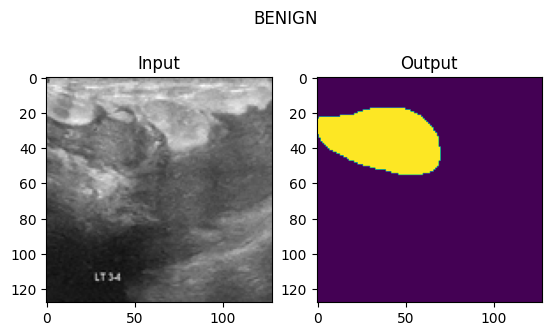

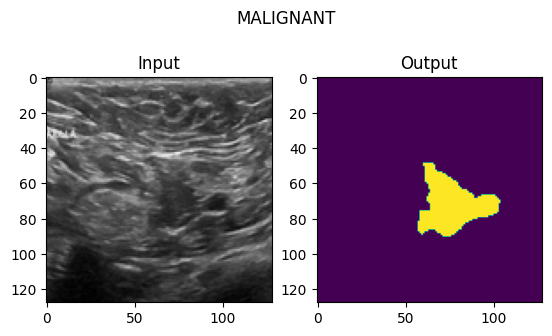

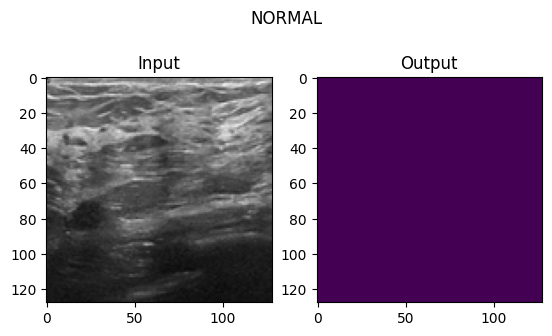

In [ ]:



for _type in ['benign', 'malignant', 'normal']:
    X = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/input.npy')
    y = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/target.npy')
    randomExample = random.randint(0, X.shape[0] - 1)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[randomExample])
    axs[0].title.set_text('Input')
    axs[1].imshow(y[randomExample])
    axs[1].title.set_text('Output')
    fig.suptitle(_type.upper())
    plt.subplots_adjust(top=1.1)
    plt.show()








In [ ]:
# For the classification task, there is a very small pool of dataa.
# As well as that there is an uneven class distribution.
# Data augmentation will address both issues.


# The types of augmentation that seem reasonable.
augmentation_config = {
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}


# Function to augment images according to the augmentation factors (explained below)
def augment_class_images(class_images, class_label, augmentation_factor, datagen):
    augmented_images = []
    augmented_labels = []
    for _ in range(augmentation_factor):
        for x in datagen.flow(class_images, batch_size=len(class_images), shuffle=False):
            augmented_images.extend(x)
            augmented_labels.extend([class_label] * len(x))
            break
    return np.array(augmented_images), np.array(augmented_labels)



# For one hot encoding the labels.
class_indices = {"benign": 0, "malignant": 1, "normal": 2}

# These factors bring us into the thousands of sample images. They decide how many augmentations each
# class of image gets to even out the distribution.
augmentation_factors = {
    0:  4,      # To augment each benign image 4 times
    1: 9,     # To augment each malignant image 9 times
    2: 14      # To augment each normal image 14 times
}


datagen = ImageDataGenerator(**augmentation_config)


# Load the data
dataset_path = '/home/tcd/data/medicalimaging/dataset/'


# Initialize lists to hold the images and labels
b_data = np.load(f'{dataset_path}''benign/input.npy')
m_data = np.load(f'{dataset_path}''malignant/input.npy')
n_data = np.load(f'{dataset_path}''normal/input.npy')

# Stick it all together
All_images = np.concatenate([b_data,m_data,n_data])

# Setting the labels to 0, 1, or 2 depending on class
labels_b = np.zeros(b_data.shape[0])
labels_m = np.ones(m_data.shape[0])
labels_n = np.full(n_data.shape[0], 2)


# Stick it all together (labels this time)
All_lables = np.concatenate([labels_b,labels_m,labels_n])


# Important, we need to split into a training and validation set before we augment data.
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(All_images, All_lables, test_size=0.4, shuffle=True)


# This is what actually one hot encodes them.
Y_train_one_hot = to_categorical(Y_train, num_classes=3) # Not completely necessary but I might need it later
Y_validation_one_hot = to_categorical(Y_validation, num_classes=3)





datagen = ImageDataGenerator(**augmentation_config)

# Initialize lists to hold the augmented images and labels
augmented_images = []
augmented_labels = []

# Call the augmentation function and fill these new lists.
b_augmented, labels_b_augmented = augment_class_images(b_data, 0, augmentation_factors[0], datagen)
m_augmented, labels_m_augmented = augment_class_images(m_data, 1, augmentation_factors[1], datagen)
n_augmented, labels_n_augmented = augment_class_images(n_data, 2, augmentation_factors[2], datagen)

# Combine the augmented images and labels for all classes
augmented_images = np.concatenate([b_augmented, m_augmented, n_augmented])
augmented_labels = np.concatenate([labels_b_augmented, labels_m_augmented, labels_n_augmented])

# One-hot encode the augmented labels
augmented_labels_one_hot = to_categorical(augmented_labels, num_classes=3)

# Combine the original TRAINING data with augmented data and labels
X_train_augmented = np.concatenate([X_train, augmented_images])
Y_train_augmented = np.concatenate([Y_train_one_hot, augmented_labels_one_hot])

In [ ]:
# This is the segmentation data code block
# Seperated from the classifcation code block.
# I'm not going to augment the data in ratios this time.

# Same augmentations as before.
augmentation_config = {
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,

}

# Same dataset path as before also.
dataset_path = '/home/tcd/data/medicalimaging/dataset/'


# Different function. Augments the original image and the segmentation map, and makes sure both get the same treatment.
def augment_images_and_masks(images, masks, augmentation_factor, datagen):

    augmented_images = []
    augmented_masks = []


    for i in range(len(images)):

        seed = np.random.randint(10000) # This is for reproducability

        # TO my understanding this produces image augmentors with the same seed, ie the same augmentations
        image_gen = datagen.flow(images[i:i+1], batch_size=1, seed=seed)
        mask_gen = datagen.flow(masks[i:i+1], batch_size=1, seed=seed)

        # Sticking on my augmented images to both sets.
        for _ in range(augmentation_factor):
            augmented_images.append(next(image_gen)[0])
            augmented_masks.append(next(mask_gen)[0])

    return np.array(augmented_images), np.array(augmented_masks)



# Same labels as before.
class_indices = {"benign": 0, "malignant": 1, "normal": 2}




# Load the original data.
b_data = np.load(f'{dataset_path}''benign/input.npy')
m_data = np.load(f'{dataset_path}''malignant/input.npy')
n_data = np.load(f'{dataset_path}''normal/input.npy')

# Stick it together
all_images = np.concatenate([b_data,m_data,n_data])


# Load the segmentation maps
b_data_segment = np.load(f'{dataset_path}''benign/target.npy')
m_data_segment = np.load(f'{dataset_path}''malignant/target.npy')
n_data_segment = np.load(f'{dataset_path}''normal/target.npy')

# Stick it together
all_segments = np.concatenate([b_data_segment, m_data_segment ,n_data_segment])

# Initialise the image generator with the augmentation configlisted at the top.
datagen_segment = ImageDataGenerator(**augmentation_config)

# As before, seperate before augmentation. We don't want to augment the validation set.
X_train_segment, X_validation_segment, Y_train_segment, Y_validation_segment = train_test_split(all_images, all_segments, test_size=0.1, shuffle=True)

# Using the function to augment images adn their respective segmentation maps.
augmented_X_train_segment, augmented_Y_train_segment = augment_images_and_masks(X_train_segment, Y_train_segment, 10, datagen_segment)

# Combine the original and augmented training data
X_train_segment_final = np.concatenate((X_train_segment, augmented_X_train_segment))
Y_train_segment_final = np.concatenate((Y_train_segment, augmented_Y_train_segment))

# Just for me to see
print(f"The training set size is: {X_train_segment_final.shape[0]} images")
print(f"The training set size is: {all_images.shape[0]} images")

The training set size is: 6930 images
The training set size is: 701 images


### The problem

You are required to train two separate neural networks for the purposes of:

1. **Classification Task**: Predicting whether an ultrasound is a) benign tumor,  b) contains a malignant tumor or c) normal (no-tumor).
    - Input are ultra sound scans (data from benign/malignant/normal), the output is a vector of the 3 probabilities for the classes (benign/malignant/normal) in that order (eg. [0.01, 0.99, 0] means the outcome is more likely to be malignant).
2. **Segmentation Task**: Predicting the segmentation map for a tumor of an input MRI scan if a tumor exists
    - Input are ultra sound scans (data from benign/malignant/normal), output is an image with the same height and width as the input image, but with only one channel and a value of 1 over the location where a tumor is present.

---

*IMPORTANT*

For Task 1, your model should be created with the name: 'classification_model',
the model size should be under 5M

For Task 2, your model should be created with the name: 'segmentation_model',
the model size should be under 3M.

In [ ]:
from keras.src.layers import AveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Transfer learning using MobileNetV2 (The GOAT)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base_model
base_model.trainable = False


x = base_model.output
x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='LeakyReLU', kernel_regularizer=l2(0.047))(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='LeakyReLU', kernel_regularizer=l2(0.047))(x)
x = Dropout(0.25)(x)

# Output layer for three classes
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


# Display a summary.
model.summary()









# Keep things sane.
if (model.count_params() > 5000000):
    raise Exception("nuh uh")















9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
# The preprocess model.
model3 = Sequential([

    Lambda(preprocess_image_tf, input_shape=(128, 128, 3)),

    # Convolutional layers
    MaxPooling2D((2, 2)),
    Conv2D(36, (3, 3), activation='LeakyReLU',kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),

    Conv2D(72, (3, 3), activation='LeakyReLU',kernel_regularizer=l2(0.0001)),
    SpatialDropout2D(0.07),
    MaxPooling2D((2, 2)),


    Flatten(),
    Dense(32, activation='LeakyReLU', kernel_regularizer=l2(0.0001)),
    Dropout(0.1),
    Dense(16, activation='LeakyReLU', kernel_regularizer=l2(0.00011)),
    Dense(3, activation='softmax')
])
opt3 = keras.optimizers.Adam(learning_rate=0.00012)

model3.compile(optimizer=opt3, loss='categorical_crossentropy', metrics=['accuracy'])


model3.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_32 (Lambda)          (None, 128, 128, 1)       0         
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 64, 64, 1)         0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 62, 62, 36)        360       
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 31, 31, 36)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 29, 29, 72)        23400     
                                                                 
 spatial_dropout2d_18 (Spat  (None, 29, 29, 72)      

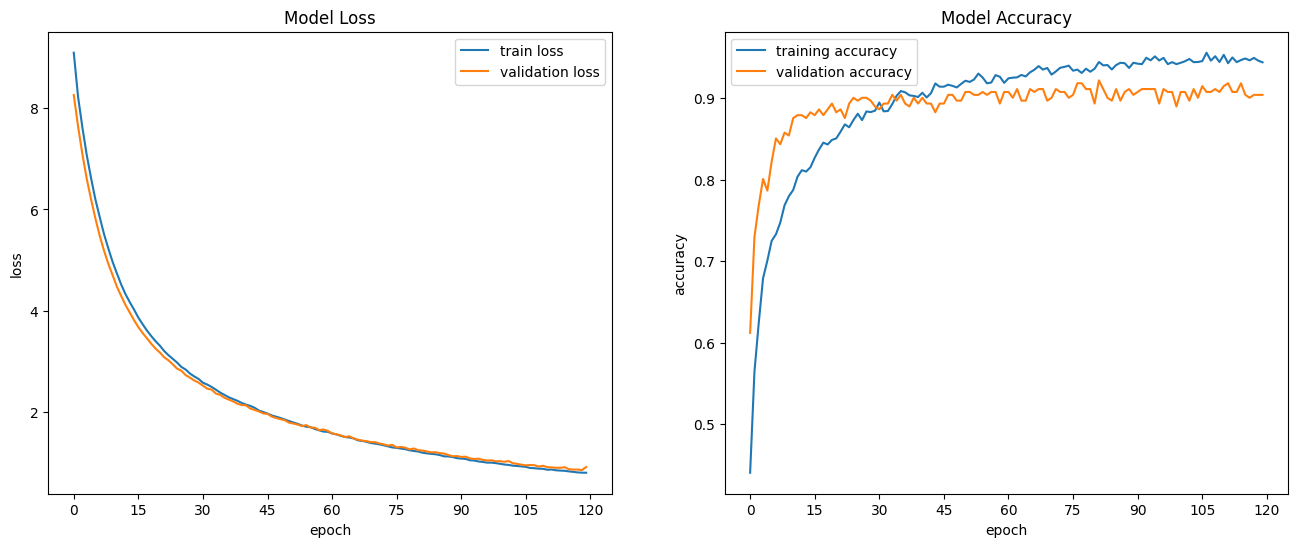

11/11 [==============================] - 3s 247ms/step - loss: 0.8053 - accuracy: 0.9438 - val_loss: 0.9183 - val_accuracy: 0.9039


In [ ]:


num_epochs = 120

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model.fit(X_train_augmented, Y_train_augmented,
          batch_size=512, epochs=num_epochs,
          validation_data=(X_validation, Y_validation_one_hot),
          callbacks=[pltCallBack])

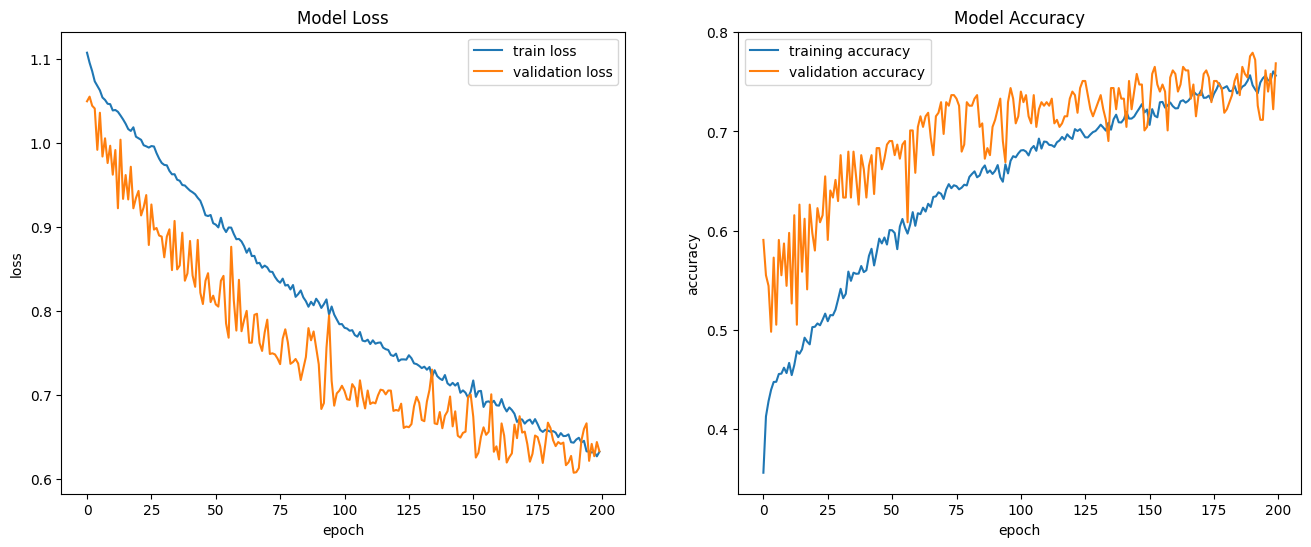

6/6 [==============================] - 2s 276ms/step - loss: 0.6321 - accuracy: 0.7563 - val_loss: 0.6327 - val_accuracy: 0.7687


In [ ]:
# Train model 3
num_epochs = 200

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model3.fit(X_train_augmented, Y_train_augmented,
          batch_size=1024, epochs=num_epochs,
          validation_data=(X_validation, Y_validation_one_hot),
          callbacks=[pltCallBack])

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Nadam

# We're going to use spatial dropout.
# Input layer
inputs = Input((128, 128, 3))

# Honestly my naming scheme for some of these layer outputs is kind of bad. Sorry.

# Contracting Path
c1 = Conv2D(16, (3, 3), activation='LeakyReLU', padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = SpatialDropout2D(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='LeakyReLU', padding='same')(c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='LeakyReLU', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = SpatialDropout2D(0.15)(c2)
c2 = Conv2D(32, (3, 3), activation='LeakyReLU', padding='same')(c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='LeakyReLU', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = SpatialDropout2D(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='LeakyReLU', padding='same')(c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='LeakyReLU', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = SpatialDropout2D(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='LeakyReLU', padding='same')(c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)




# Bottleneck
c5 = Conv2D(256, (3, 3), activation='LeakyReLU', padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = SpatialDropout2D(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='LeakyReLU', padding='same')(c5)
c5 = BatchNormalization()(c5)



# en will will match cn in size. They will be concatenated.



# Expansive Path
e4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
e4 = concatenate([e4, c4])
c6 = Conv2D(128, (3, 3), activation='LeakyReLU', padding='same')(e4)
c6 = BatchNormalization()(c6)
c6 = SpatialDropout2D(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='LeakyReLU', padding='same')(c6)
c6 = BatchNormalization()(c6)

e3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c6)
e3 = concatenate([e3, c3])
c7 = Conv2D(64, (3, 3), activation='LeakyReLU', padding='same')(e3)
c7 = BatchNormalization()(c7)
c7 = SpatialDropout2D(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='LeakyReLU', padding='same')(c7)
c7 = BatchNormalization()(c7)

e2 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c7)
e2 = concatenate([e2, c2])
c8 = Conv2D(32, (3, 3), activation='LeakyReLU', padding='same')(e2)
c8 = BatchNormalization()(c8)
c8 = SpatialDropout2D(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='LeakyReLU', padding='same')(c8)
c8 = BatchNormalization()(c8)

e1 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c8)
e1 = concatenate([e1, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='LeakyReLU', padding='same')(e1)
c9 = BatchNormalization()(c9)
c9 = SpatialDropout2D(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='LeakyReLU', padding='same')(c9)
c9 = BatchNormalization()(c9)

# Output layer
output_img = Conv2D(1, (1, 1), activation='sigmoid')(c9)

opt2 = keras.optimizers.Adam(learning_rate=0.000075)

model2 = Model(inputs=inputs, outputs=output_img)

# Compile the model
model2.compile(optimizer=opt2, loss=combined_loss, metrics=[f1_score])

# Model summary
model2.summary()

if (model2.count_params()  < 3000000) :
  print("Your model is unecessarily complex, scale down!")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 spatial_dropout2d (Spatial  (None, 128, 128, 16)         0         ['batch_normalization[0]

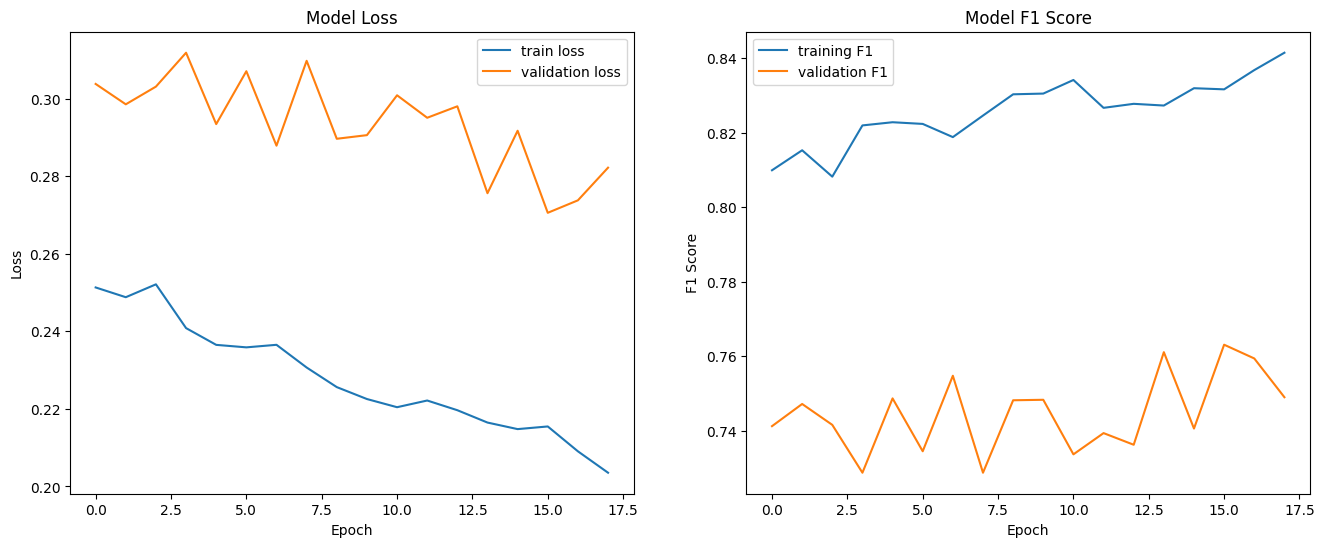

28/28 [==============================] - 28s 991ms/step - loss: 0.2036 - f1_score: 0.8415 - val_loss: 0.2822 - val_f1_score: 0.7490
Epoch 19/80
12/28 [===========>..................] - ETA: 16s - loss: 0.2027 - f1_score: 0.8407

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 80

# Same as above but for the segmentation model
pltCallBack = PlotLossF1()

# Run the training.
model2.fit(X_train_segment_final, Y_train_segment_final,
          batch_size=256, epochs=num_epochs,
          validation_data=(X_validation_segment, Y_validation_segment),
          callbacks=[pltCallBack])

In [ ]:
classification_model = model
if (classification_model.count_params()  < 5000000) :
  save_model_to_disk(classification_model, "classification_model")
else:
  print("Your model is unecessarily complex, scale down!")

NameError: ignored

In [ ]:
segmentation_model = model2

if (segmentation_model.count_params()  < 3000000) :
  save_model_to_disk(segmentation_model, "segmentation_model")
else:
  print("Your model is unecessarily complex, scale down!")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-1218a295efa5>", line 4, in <cell line: 3>
    save_model_to_disk(segmentation_model, "segmentation_model")
  File "<ipython-input-20-c094a3832284>", line 45, in save_model_to_disk
    with open(filename_base + ".json", "w") as json_file:
OSError: [Errno 107] Transport endpoint is not connected: 'segmentation_model.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/pytho